# Flyte Demo

- Register all tasks
- Create a data preparation workflow by composing these tasks
- Create an orchasteration workflow by composing other workflows
- Visualize the output

In [27]:
# We will use our own staging environment for the live demo!
import os
os.environ['FLYTE_PLATFORM_URL'] = "flyte-staging.lyft.net"
version = "fake14"

In [28]:
# Register existing tasks/workflows with the system
from flytekit.clis.sdk_in_container.register import register_all, register_tasks_only
import os 
from flytekit.configuration import set_flyte_config_file

os.environ["FLYTE_INTERNAL_IMAGE"] = "docker.io/lyft/flytekubecondemo2019:90f2cf9697e9478b8b165effc3d411ff51519f4c"
set_flyte_config_file("staging.config")
os.environ["FLYTE_INTERNAL_CONFIGURATION_PATH"] = "/app/staging.config"

register_all("flytekubecondemo2019", "development", ["workflows"], version=version, test=False)

Running task, workflow, and launch plan registration for flytekubecondemo2019, development, ['workflows'] with version fake14
Registering Task:                workflows.classifier_evaluate_workflow.analyze_prediction_results
Registering Task:                workflows.classifier_evaluate_workflow.generate_predictions
Registering Task:                workflows.classifier_evaluate_workflow.fetch_model
Registering Task:                workflows.classifier_train_workflow.rearrange_data
Registering Task:                workflows.classifier_evaluate_workflow.evaluate_on_datasets
Registering Workflow:            workflows.classifier_evaluate_workflow.ClassifierEvaluateWorkflow
Registering Launch Plan:         workflows.classifier_evaluate_workflow.ClassifierEvaluateWorkflow
Registering Launch Plan:         workflows.classifier_evaluate_workflow.evaluate_lp
Registering Task:                workflows.classifier_evaluate_workflow.predict
Registering Task:                workflows.classifier_evalu

# Orchasterator Workflow

- Use data preparation, training and evaluation workflows to compose an orchasterator worklfow
- Kick of an execution and wait for completion
- Visualize the output

In [29]:
# The Driver Workflow
import ujson
from flytekit.common.tasks.task import SdkTask
from flytekit.sdk.tasks import python_task, inputs, outputs
from flytekit.sdk.types import Types
from flytekit.sdk.workflow import workflow_class, Output, Input
from workflows.classifier_evaluate_workflow import evaluate_lp
from workflows.classifier_train_workflow import train_lp, DEFAULT_VALIDATION_DATA_RATIO, \
    DEFAULT_TRAINING_VALIDATION_CONFIG_FILE
from workflows.data_preparation_workflow import data_prep
from workflows.driver_workflow import pick_second

DEFAULT_TRAINING_CONFIG_FILE = "models/classifier/resnet50/configs/model_training_config_demo.json"
DEFAULT_EVALUATION_CONFIG_FILE = "models/classifier/resnet50/configs/model_evaluation_config_demo.json"


## Consume a task from a different project
# compute_confusion_matrix = SdkTask.fetch(
#     project="kubecondemo2019-metrics",
#     domain="development",
#     name="demo_metrics.tasks.confusion_matrix.confusion_matrix",
#     version="66b463748f25ef71c8cd4eb3001f00eafb83efc6",
# )


@workflow_class
class Orchestrator:
    # Define inputs
    streams_external_storage_prefix = Input(Types.String, required=True)
    streams_names = Input([Types.String], required=True)
    stream_extension = Input(Types.String, default="avi")

    streams_metadata_path = Input(Types.String, required=True)
    training_validation_config_json = Input(Types.Generic,
                                            default=ujson.loads(open(DEFAULT_TRAINING_CONFIG_FILE).read()))
    validation_data_ratio = Input(Types.Float, default=DEFAULT_VALIDATION_DATA_RATIO)
    evaluation_config_json = Input(Types.Generic,
                                   default=ujson.loads(open(DEFAULT_EVALUATION_CONFIG_FILE).read()))

    # Define workflow steps
    prepare = data_prep(
        streams_external_storage_prefix=streams_external_storage_prefix,
        streams_names=streams_names,
        stream_extension=stream_extension)

    train = train_lp(
        available_streams_names=prepare.outputs.streams_names_out,
        available_streams_mpblobs=prepare.outputs.selected_frames_mpblobs,
        streams_metadata_path=streams_metadata_path,
        training_validation_config_json=training_validation_config_json,
        validation_data_ratio=validation_data_ratio
    )

    pick_second = pick_second(models=train.outputs.trained_models)

    evaluate = evaluate_lp(
        available_streams_names=prepare.outputs.streams_names_out,
        available_streams_mpblobs=prepare.outputs.selected_frames_mpblobs,
        streams_metadata_path=streams_metadata_path,
        evaluation_config_json=evaluation_config_json,
        model=pick_second.outputs.second,
        validation_data_ratio=validation_data_ratio
    )

#     confusion_matrix_task = compute_confusion_matrix(
#         y_true=evaluate.outputs.ground_truths,
#         y_pred=evaluate.outputs.predictions,
#         title="Confusion Matrix",
#         normalize=True,
#         classes=["busy", "clear"],
#     )

    # Define workflow outputs
    ground_truths = Output(evaluate.outputs.ground_truths, sdk_type=[Types.Integer])
    predictions = Output(evaluate.outputs.predictions, sdk_type=[Types.Integer])
#     confusion_matrix_image = Output(confusion_matrix_task.outputs.visual, sdk_type=Types.Blob)


orchestrator_lp = Orchestrator.create_launch_plan()

Orchestrator.register("flytekubecondemo2019", "development", "Orchestrator", version)
orchestrator_lp.register("flytekubecondemo2019", "development", "Orchestrator", version)

'lp:flytekubecondemo2019:development:Orchestrator:fake14'

In [30]:
# Kick of an execution
execution = orchestrator_lp.execute("flytekubecondemo2019", "development", inputs={
    'streams_external_storage_prefix': 's3://lyft-modelbuilder/metadata/_FlyteKubeconDemo2019Dataset/streams',
    'streams_names': ["1537396038_cam-rgb-1","1537396038_cam-rgb-2","1537396662_cam-rgb-1","1537396662_cam-rgb-2","1537396790_cam-rgb-1","1537396790_cam-rgb-2","1537396942_cam-rgb-1","1537396942_cam-rgb-2","1538521877_cam-rgb-1","1538521877_cam-rgb-2","1538521964_cam-rgb-1","1538521964_cam-rgb-2","1538522195_cam-rgb-1","1538522195_cam-rgb-2","1538522386_cam-rgb-1","1538522386_cam-rgb-2","1538522615_cam-rgb-1","1538522615_cam-rgb-2","1538522881_cam-rgb-1","1538522881_cam-rgb-2","1538523052_cam-rgb-1","1538523052_cam-rgb-2","1538523280_cam-rgb-1","1538523280_cam-rgb-2","1538523741_cam-rgb-1","1538523741_cam-rgb-2","1538523916_cam-rgb-1","1538523916_cam-rgb-2","1538524089_cam-rgb-1","1538524089_cam-rgb-2","1539390982_cam-rgb-1","1539390982_cam-rgb-2","1539391169_cam-rgb-1","1539391169_cam-rgb-2","1539391321_cam-rgb-1","1539391321_cam-rgb-2","1539391462_cam-rgb-1","1539391462_cam-rgb-2","1539391643_cam-rgb-1","1539391643_cam-rgb-2","1539391807_cam-rgb-1","1539391807_cam-rgb-2","1539391941_cam-rgb-1","1539391941_cam-rgb-2","1539471715_cam-rgb-1","1539471715_cam-rgb-2","1539471904_cam-rgb-1","1539471904_cam-rgb-2","1539475636_cam-rgb-1","1539475636_cam-rgb-2"],
    'streams_metadata_path': 's3://lyft-modelbuilder/metadata/_FlyteKubeconDemo2019Dataset/metadata/streams_metadata.json',
})

# from flytekit.common.workflow_execution import SdkWorkflowExecution
# execution = SdkWorkflowExecution.fetch(project="flytekubecondemo2019", domain="development", name="f41bd0f1e10c64c67a91")
print("Started execution: {}".format(execution.id))

Started execution: ex:flytekubecondemo2019:development:f337aca7e1cfa4186916


In [9]:
execution.wait_for_completion()
print(execution.outputs)

{'confusion_matrix_image': metadata {
  type {
  }
}
uri: "s3://lyft-modelbuilder/bl/a40c60bf33f25a88cab655ba013b5364"
}


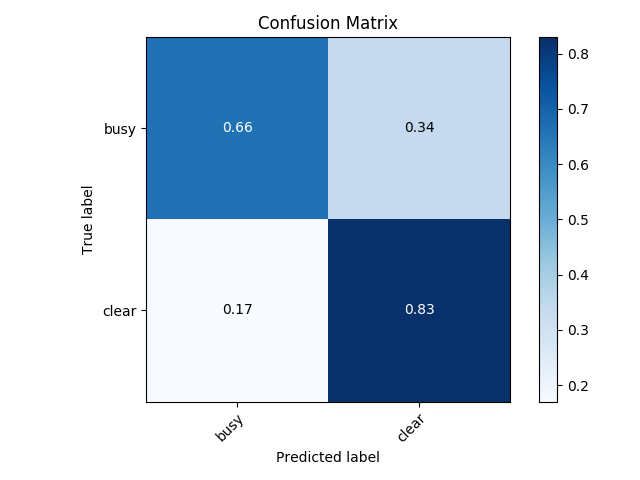

In [10]:
local_file = "/tmp/cm-4.png"
execution.outputs["confusion_matrix_image"].download(local_file, overwrite=True)
from IPython.display import Image
Image(filename=local_file)